In [26]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 16

In [27]:
print(dir())

['In', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'batch_size', 'class_names', 'data_dir', 'exit', 'get_ipython', 'image_batch', 'img_height', 'img_width', 'inspect', 'labels_batch', 'model_dictionary', 'num_classes', 'num_iterations', 'num_train', 'num_validation', 'pd', 'plt', 'quit', 'tf', 'tfds', 'tqdm', 'train', 'validation']


In [28]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [29]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images" 

In [30]:
# We need to define some parameters for the laoder: 
img_height = 400
img_width = 400

In [31]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1340 files belonging to 2 classes.
Using 1072 files for training.
Found 1340 files belonging to 2 classes.
Using 268 files for validation.


In [32]:
class_names = train.class_names
print(class_names)

['rope', 'snake']


In [33]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 400, 400, 3)
(16,)


In [34]:
# Number of training examples and labels
num_train = len(train)
num_validation = len(validation)
num_classes = len(class_names)
num_iterations = int(num_train/batch_size)

In [35]:
# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 67         
Num validation images: 17         
Num classes: 2         
Num iterations per epoch: 4


In [38]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label
    
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    #train_processed = train_processed.batch(batch_size).repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    #validation_processed = validation_processed.batch(batch_size)
    
    return train_processed, validation_processed
    
# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])


In [41]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False
    
    # custom modifications on top of pre-trained model and fit
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, steps_per_epoch=num_iterations)
    
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Epoch 1/3


2022-01-27 10:39:56.935879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.5781

2022-01-27 10:40:14.916512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 42s 9s/step - loss: 0.9945 - accuracy: 0.5781 - val_loss: 0.7714 - val_accuracy: 0.6082
Epoch 2/3
4/4 [==============================] - 14s 4s/step - loss: 0.6746 - accuracy: 0.6719 - val_loss: 0.6353 - val_accuracy: 0.6567
Epoch 3/3
4/4 [==============================] - 14s 4s/step - loss: 0.6552 - accuracy: 0.6875 - val_loss: 0.5735 - val_accuracy: 0.7015


  4%|█▌                                          | 1/28 [01:11<32:13, 71.60s/it]

Epoch 1/3


2022-01-27 10:41:14.958400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.6406

2022-01-27 10:41:30.774984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 42s 10s/step - loss: 0.6753 - accuracy: 0.6406 - val_loss: 0.5081 - val_accuracy: 0.7425
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.4031 - accuracy: 0.8438 - val_loss: 0.4097 - val_accuracy: 0.8396
Epoch 3/3
4/4 [==============================] - 16s 5s/step - loss: 0.3106 - accuracy: 0.8906 - val_loss: 0.3909 - val_accuracy: 0.8209


  7%|███▏                                        | 2/28 [02:32<33:20, 76.92s/it]

Epoch 1/3


2022-01-27 10:42:33.824971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.2544 - accuracy: 0.3125

2022-01-27 10:42:52.945117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 58s 13s/step - loss: 1.2544 - accuracy: 0.3125 - val_loss: 0.7448 - val_accuracy: 0.5373
Epoch 2/3
4/4 [==============================] - 19s 6s/step - loss: 0.6341 - accuracy: 0.5625 - val_loss: 0.5566 - val_accuracy: 0.7052
Epoch 3/3
4/4 [==============================] - 18s 5s/step - loss: 0.5158 - accuracy: 0.7344 - val_loss: 0.5855 - val_accuracy: 0.6754


 11%|████▋                                       | 3/28 [04:09<35:54, 86.18s/it]

Epoch 1/3


2022-01-27 10:44:06.869228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.5156

2022-01-27 10:44:19.947045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 33s 7s/step - loss: 0.7145 - accuracy: 0.5156 - val_loss: 0.6939 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.7083 - accuracy: 0.4375 - val_loss: 0.6933 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 14s 4s/step - loss: 0.7005 - accuracy: 0.4688 - val_loss: 0.6932 - val_accuracy: 0.5224


 14%|██████▎                                     | 4/28 [05:13<30:55, 77.32s/it]

Epoch 1/3


2022-01-27 10:45:16.160231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.4375

2022-01-27 10:45:29.820235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 40s 9s/step - loss: 0.7274 - accuracy: 0.4375 - val_loss: 0.6966 - val_accuracy: 0.4776
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.6642 - accuracy: 0.6406 - val_loss: 0.7296 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 14s 5s/step - loss: 0.7254 - accuracy: 0.5156 - val_loss: 0.6926 - val_accuracy: 0.5224


 18%|███████▊                                    | 5/28 [06:28<29:23, 76.66s/it]

Epoch 1/3


2022-01-27 10:46:26.577175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.5312

2022-01-27 10:46:44.089339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 44s 9s/step - loss: 0.6994 - accuracy: 0.5312 - val_loss: 0.7139 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 15s 4s/step - loss: 0.7049 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 14s 5s/step - loss: 0.6910 - accuracy: 0.5781 - val_loss: 0.7091 - val_accuracy: 0.5224


 21%|█████████▍                                  | 6/28 [07:43<27:51, 75.96s/it]

Epoch 1/3


2022-01-27 10:47:41.141773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.8312 - accuracy: 0.4062

2022-01-27 10:47:57.308364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 44s 9s/step - loss: 0.8312 - accuracy: 0.4062 - val_loss: 0.7293 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 16s 5s/step - loss: 0.6910 - accuracy: 0.5312 - val_loss: 0.7348 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 15s 5s/step - loss: 0.6957 - accuracy: 0.6250 - val_loss: 0.7012 - val_accuracy: 0.5224


 25%|███████████                                 | 7/28 [08:59<26:38, 76.11s/it]

Epoch 1/3


2022-01-27 10:49:03.420892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.5000

2022-01-27 10:49:24.888354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 60s 12s/step - loss: 0.7287 - accuracy: 0.5000 - val_loss: 0.7871 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 19s 6s/step - loss: 0.7599 - accuracy: 0.5938 - val_loss: 0.6922 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 16s 5s/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.7215 - val_accuracy: 0.4776


 29%|████████████▌                               | 8/28 [10:36<27:31, 82.58s/it]

Epoch 1/3


2022-01-27 10:50:36.338408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.4531

2022-01-27 10:51:01.676053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 62s 13s/step - loss: 0.8379 - accuracy: 0.4531 - val_loss: 0.7032 - val_accuracy: 0.4776
Epoch 2/3
4/4 [==============================] - 18s 6s/step - loss: 0.6785 - accuracy: 0.5938 - val_loss: 0.7223 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 16s 5s/step - loss: 0.6721 - accuracy: 0.6406 - val_loss: 0.6851 - val_accuracy: 0.5410


 32%|██████████████▏                             | 9/28 [12:15<27:46, 87.74s/it]

Epoch 1/3


2022-01-27 10:52:20.686399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.5469

2022-01-27 10:52:45.284767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 68s 15s/step - loss: 0.7641 - accuracy: 0.5469 - val_loss: 0.8060 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 20s 6s/step - loss: 0.6975 - accuracy: 0.5781 - val_loss: 0.7005 - val_accuracy: 0.4776
Epoch 3/3
4/4 [==============================] - 19s 6s/step - loss: 0.7283 - accuracy: 0.4375 - val_loss: 0.7426 - val_accuracy: 0.4776


 36%|███████████████▎                           | 10/28 [14:10<28:50, 96.16s/it]

Epoch 1/3


2022-01-27 10:54:15.339543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.9213 - accuracy: 0.5312

2022-01-27 10:54:43.892626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 82s 18s/step - loss: 0.9213 - accuracy: 0.5312 - val_loss: 0.8119 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 24s 8s/step - loss: 0.7836 - accuracy: 0.4219 - val_loss: 0.7245 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 25s 8s/step - loss: 0.6800 - accuracy: 0.6094 - val_loss: 0.7475 - val_accuracy: 0.5224


 39%|████████████████▌                         | 11/28 [16:27<30:51, 108.89s/it]

Epoch 1/3


2022-01-27 10:56:32.454627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.5000

2022-01-27 10:56:55.573818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 82s 18s/step - loss: 1.2884 - accuracy: 0.5000 - val_loss: 0.7906 - val_accuracy: 0.5149
Epoch 2/3
4/4 [==============================] - 18s 5s/step - loss: 0.7001 - accuracy: 0.5938 - val_loss: 0.5032 - val_accuracy: 0.8097
Epoch 3/3
4/4 [==============================] - 14s 5s/step - loss: 0.5994 - accuracy: 0.6875 - val_loss: 0.4264 - val_accuracy: 0.8433


 43%|██████████████████                        | 12/28 [18:25<29:45, 111.58s/it]

Epoch 1/3


2022-01-27 10:58:22.782938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.6250

2022-01-27 10:58:36.462856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 36s 7s/step - loss: 1.4463 - accuracy: 0.6250 - val_loss: 0.5019 - val_accuracy: 0.7649
Epoch 2/3
4/4 [==============================] - 13s 4s/step - loss: 0.5292 - accuracy: 0.7344 - val_loss: 0.4502 - val_accuracy: 0.7649
Epoch 3/3
4/4 [==============================] - 12s 4s/step - loss: 0.5541 - accuracy: 0.7344 - val_loss: 0.6318 - val_accuracy: 0.6418


 46%|███████████████████▉                       | 13/28 [19:28<24:11, 96.77s/it]

Epoch 1/3


2022-01-27 10:59:23.509538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.5938

2022-01-27 10:59:32.738751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 22s 5s/step - loss: 0.8998 - accuracy: 0.5938 - val_loss: 0.8094 - val_accuracy: 0.6269
Epoch 2/3
4/4 [==============================] - 12s 4s/step - loss: 0.5677 - accuracy: 0.7188 - val_loss: 0.5890 - val_accuracy: 0.7201
Epoch 3/3
4/4 [==============================] - 12s 4s/step - loss: 0.4961 - accuracy: 0.7188 - val_loss: 0.4723 - val_accuracy: 0.7761


 50%|█████████████████████▌                     | 14/28 [20:14<18:59, 81.36s/it]

Epoch 1/3


2022-01-27 11:00:09.726408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6719

2022-01-27 11:00:19.894245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 25s 5s/step - loss: 0.6090 - accuracy: 0.6719 - val_loss: 0.5962 - val_accuracy: 0.7090
Epoch 2/3
4/4 [==============================] - 12s 4s/step - loss: 0.3929 - accuracy: 0.8281 - val_loss: 0.4311 - val_accuracy: 0.8022
Epoch 3/3
4/4 [==============================] - 12s 4s/step - loss: 0.3311 - accuracy: 0.8750 - val_loss: 0.3798 - val_accuracy: 0.8321


 54%|███████████████████████                    | 15/28 [21:03<15:32, 71.72s/it]

Epoch 1/3


2022-01-27 11:00:59.541637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.8646 - accuracy: 0.5781 

2022-01-27 11:02:39.489322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 848s 279s/step - loss: 0.8646 - accuracy: 0.5781 - val_loss: 0.7002 - val_accuracy: 0.5261
Epoch 2/3
4/4 [==============================] - 1080s 360s/step - loss: 0.7109 - accuracy: 0.5625 - val_loss: 0.6911 - val_accuracy: 0.5261
Epoch 3/3
4/4 [==============================] - 827s 276s/step - loss: 0.6970 - accuracy: 0.5625 - val_loss: 0.6637 - val_accuracy: 0.5336


 57%|█████████████████████▋                | 16/28 [1:07:00<2:55:59, 879.93s/it]

Epoch 1/3


2022-01-27 11:49:05.506527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5469

2022-01-27 11:49:17.728049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 156s 5s/step - loss: 0.6982 - accuracy: 0.5469 - val_loss: 0.6810 - val_accuracy: 0.4776
Epoch 2/3
4/4 [==============================] - 12s 4s/step - loss: 0.7356 - accuracy: 0.3594 - val_loss: 0.7111 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 12s 4s/step - loss: 0.7038 - accuracy: 0.5625 - val_loss: 0.6857 - val_accuracy: 0.5224


 61%|███████████████████████               | 17/28 [1:10:00<2:02:45, 669.59s/it]

Epoch 1/3


2022-01-27 11:50:03.175375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.5938

2022-01-27 11:50:52.402618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 126s 30s/step - loss: 0.6521 - accuracy: 0.5938 - val_loss: 0.4769 - val_accuracy: 0.7873
Epoch 2/3
4/4 [==============================] - 43s 13s/step - loss: 0.3994 - accuracy: 0.8438 - val_loss: 0.3986 - val_accuracy: 0.8172
Epoch 3/3
4/4 [==============================] - 42s 13s/step - loss: 0.3619 - accuracy: 0.9219 - val_loss: 0.3370 - val_accuracy: 0.8843


 64%|████████████████████████▍             | 18/28 [1:13:36<1:28:53, 533.33s/it]

Epoch 1/3


2022-01-27 11:53:38.270212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.6562

2022-01-27 11:54:05.192390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 70s 15s/step - loss: 0.6196 - accuracy: 0.6562 - val_loss: 0.5039 - val_accuracy: 0.7612
Epoch 2/3
4/4 [==============================] - 14s 4s/step - loss: 0.4294 - accuracy: 0.8281 - val_loss: 0.4432 - val_accuracy: 0.7948
Epoch 3/3
4/4 [==============================] - 15s 5s/step - loss: 0.4400 - accuracy: 0.8281 - val_loss: 0.4125 - val_accuracy: 0.8396


 68%|█████████████████████████▊            | 19/28 [1:15:19<1:00:34, 403.85s/it]

Epoch 1/3


2022-01-27 11:55:22.643318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.4062

2022-01-27 11:55:40.519960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 52s 10s/step - loss: 0.7530 - accuracy: 0.4062 - val_loss: 0.6885 - val_accuracy: 0.5373
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.6834 - accuracy: 0.5781 - val_loss: 0.6953 - val_accuracy: 0.5299
Epoch 3/3
4/4 [==============================] - 14s 5s/step - loss: 0.7032 - accuracy: 0.5156 - val_loss: 0.6782 - val_accuracy: 0.5522


 71%|████████████████████████████▌           | 20/28 [1:16:41<40:59, 307.39s/it]

Epoch 1/3


2022-01-27 11:56:38.698409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.6719

2022-01-27 11:56:55.025279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 44s 10s/step - loss: 0.7472 - accuracy: 0.6719 - val_loss: 0.3760 - val_accuracy: 0.8321
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.3328 - accuracy: 0.8281 - val_loss: 0.2937 - val_accuracy: 0.8881
Epoch 3/3
4/4 [==============================] - 14s 4s/step - loss: 0.2309 - accuracy: 0.8750 - val_loss: 0.4123 - val_accuracy: 0.8097


 75%|██████████████████████████████          | 21/28 [1:17:55<27:41, 237.40s/it]

Epoch 1/3


2022-01-27 11:57:54.412973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5938

2022-01-27 11:58:18.021313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 64s 15s/step - loss: 0.7009 - accuracy: 0.5938 - val_loss: 0.6835 - val_accuracy: 0.5560
Epoch 2/3
4/4 [==============================] - 18s 6s/step - loss: 0.7055 - accuracy: 0.5000 - val_loss: 0.6749 - val_accuracy: 0.6194
Epoch 3/3
4/4 [==============================] - 17s 5s/step - loss: 0.6962 - accuracy: 0.6094 - val_loss: 0.6734 - val_accuracy: 0.5634


 79%|███████████████████████████████▍        | 22/28 [1:19:36<19:38, 196.46s/it]

Epoch 1/3


2022-01-27 11:59:40.011039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.5156

2022-01-27 12:00:00.176997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 55s 13s/step - loss: 1.1154 - accuracy: 0.5156 - val_loss: 0.5182 - val_accuracy: 0.7201
Epoch 2/3
4/4 [==============================] - 17s 5s/step - loss: 0.5590 - accuracy: 0.7500 - val_loss: 0.3914 - val_accuracy: 0.7985
Epoch 3/3
4/4 [==============================] - 17s 5s/step - loss: 0.4219 - accuracy: 0.7812 - val_loss: 0.3179 - val_accuracy: 0.8545


 82%|████████████████████████████████▊       | 23/28 [1:21:12<13:50, 166.08s/it]

94781440/94765736 [==============================] - 7s 0us/step
Epoch 1/3


2022-01-27 12:01:15.891858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.6250

2022-01-27 12:01:27.993789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 31s 7s/step - loss: 0.7054 - accuracy: 0.6250 - val_loss: 0.8526 - val_accuracy: 0.5224
Epoch 2/3
4/4 [==============================] - 14s 4s/step - loss: 0.7035 - accuracy: 0.5938 - val_loss: 0.6995 - val_accuracy: 0.5224
Epoch 3/3
4/4 [==============================] - 16s 5s/step - loss: 0.7625 - accuracy: 0.3594 - val_loss: 0.6849 - val_accuracy: 0.6194


 86%|██████████████████████████████████▎     | 24/28 [1:22:21<09:08, 137.00s/it]

94683136/94668760 [==============================] - 55s 1us/step
Epoch 1/3


2022-01-27 12:03:14.069719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.0371 - accuracy: 0.5781

2022-01-27 12:03:26.063320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 31s 7s/step - loss: 1.0371 - accuracy: 0.5781 - val_loss: 0.6366 - val_accuracy: 0.6530
Epoch 2/3
4/4 [==============================] - 13s 4s/step - loss: 0.5726 - accuracy: 0.7500 - val_loss: 0.4415 - val_accuracy: 0.7836
Epoch 3/3
4/4 [==============================] - 14s 4s/step - loss: 0.3682 - accuracy: 0.8438 - val_loss: 0.3528 - val_accuracy: 0.8433


 89%|███████████████████████████████████▋    | 25/28 [1:24:17<06:32, 130.89s/it]

Epoch 1/3


2022-01-27 12:04:12.850974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5781

2022-01-27 12:04:22.312617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 12:04:33.302395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 89 of 128
2022-01-27 12:04:38.827757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


4/4 [==============================] - 35s 9s/step - loss: 0.6901 - accuracy: 0.5781 - val_loss: 0.6670 - val_accuracy: 0.5821
Epoch 2/3
4/4 [==============================] - 15s 5s/step - loss: 0.6343 - accuracy: 0.6406 - val_loss: 0.6511 - val_accuracy: 0.6306
Epoch 3/3
4/4 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.6719

2022-01-27 12:05:13.961368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 89 of 128
2022-01-27 12:05:15.183049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


4/4 [==============================] - 20s 7s/step - loss: 0.5921 - accuracy: 0.6719 - val_loss: 0.6567 - val_accuracy: 0.5560


 93%|█████████████████████████████████████▏  | 26/28 [1:25:28<03:45, 112.71s/it]

80150528/80134624 [==============================] - 6s 0us/step
Epoch 1/3


2022-01-27 12:05:30.438064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.5156

2022-01-27 12:05:39.566245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 28s 7s/step - loss: 0.6809 - accuracy: 0.5156 - val_loss: 0.6522 - val_accuracy: 0.6791
Epoch 2/3
4/4 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.6094

2022-01-27 12:06:10.153467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 109 of 128
2022-01-27 12:06:11.153676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


4/4 [==============================] - 26s 8s/step - loss: 0.6428 - accuracy: 0.6094 - val_loss: 0.6470 - val_accuracy: 0.5784
Epoch 3/3
4/4 [==============================] - 20s 6s/step - loss: 0.6297 - accuracy: 0.6094 - val_loss: 0.6313 - val_accuracy: 0.7799


 96%|██████████████████████████████████████▌ | 27/28 [1:26:49<01:43, 103.19s/it]

83697664/83683744 [==============================] - 7s 0us/step
Epoch 1/3


2022-01-27 12:06:58.400724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.6250

2022-01-27 12:07:11.929848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 38s 7s/step - loss: 0.6557 - accuracy: 0.6250 - val_loss: 0.5736 - val_accuracy: 0.6567
Epoch 2/3
4/4 [==============================] - 14s 5s/step - loss: 0.4072 - accuracy: 0.8125 - val_loss: 0.4222 - val_accuracy: 0.8396
Epoch 3/3
4/4 [==============================] - 14s 4s/step - loss: 0.3935 - accuracy: 0.8281 - val_loss: 0.4213 - val_accuracy: 0.8022


100%|████████████████████████████████████████| 28/28 [1:28:03<00:00, 188.71s/it]


In [42]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

,model_name,num_model_params,validation_accuracy
16,MobileNetV3Small,1529968,0.522388
14,MobileNetV2,2257984,0.832090
13,MobileNet,3228864,0.776119
3,EfficientNetB0,4049571,0.522388
15,MobileNetV3Large,4226432,0.533582
18,NASNetMobile,4269716,0.839552
4,EfficientNetB1,6575239,0.522388
0,DenseNet121,7037504,0.701493
5,EfficientNetB2,7768569,0.522388
6,EfficientNetB3,10783535,0.522388


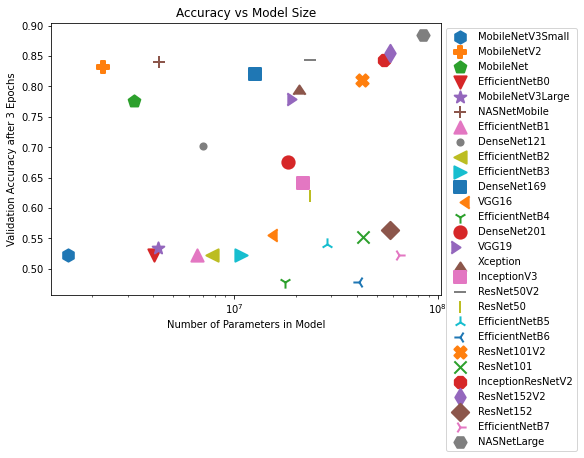

In [43]:

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');